In [60]:
import warnings; warnings.simplefilter('ignore')

from scipy.io import wavfile
import pandas as pd
import numpy as np
from plotnine import *
theme_set(theme_bw())

def audio_to_dataframe(path):
    from scipy.io import wavfile
    
    sample_rate, data = wavfile.read(path)
    ret_obj = (
        pd.DataFrame(data, columns=['left', 'right'])
          .assign(time_id = range(len(data)),
                  file_id = path)
    )
    return ret_obj

def abbreviate_label(s, max_len=20, connect_string='...'):
    if len(s) > max_len:
        return s[:int(max_len/2)] + connect_string + s[int(-max_len/2):]
    else:
        return s

## Coef path plots
def plot_coef_paths(cv_results, category, X_data):
    feature_list = pd.Series(range(len(X_data.columns) + 1)) # +1 for intercept
    feature_list.index =  list(X_data.columns) + ['intercept']

    def transform_coef_path(feature_index, feature_name):
        return (
                pd.DataFrame(cv_results.coefs_paths_[category][:,:,feature_index], columns=cs)
                 .melt(var_name='reg_strength', value_name='coef_value')
                 .assign(feature_name=feature_name)
              )
    plot_data = pd.concat([transform_coef_path(value, index) for index, value in feature_list.iteritems()])
    plot_data = plot_data.assign(reg_strength = np.log10(1/(2*plot_data["reg_strength"])))
    mean_coef_values = plot_data.groupby(['feature_name']).mean()
    relevant_features = mean_coef_values.query('coef_value > 1e-8').index
    plot_data = plot_data[plot_data['feature_name'].isin(relevant_features)]

    coef_from_high_to_low = plot_data.groupby(['feature_name']).mean().abs().sort_values(by='coef_value', ascending=False).index
    plot_data['feature_name'] = pd.Categorical(plot_data['feature_name'], categories=coef_from_high_to_low)

    plot_data_min_max = plot_data.groupby(['reg_strength', 'feature_name']).agg(['min', 'max'])
    plot_data_min_max.columns = ['_'.join(col).strip() for col in plot_data_min_max.columns.values] 
    plot_data_min_max = plot_data_min_max.reset_index()

    return (
        ggplot(plot_data) + 
          geom_ribbon(plot_data_min_max, aes(x='reg_strength', ymin='coef_value_min', ymax='coef_value_max'), fill='lightgrey') + 
          geom_point(aes(x='reg_strength', y='coef_value'), alpha=0.8) + 
          facet_wrap('~ feature_name', labeller=abbreviate_label) + 
          labs(x='Regularisation strength [log10(1/2C)]', y='Coefficient value [-]')
    )

## Overall performance plots
def get_data_per_model(data_for_model, model_name, cs_values):
    plot_data = (
        pd.DataFrame(data_for_model, columns=cs_values)
          .melt(var_name='reg_strength', value_name='cv_score')
          .groupby('reg_strength')
          .agg(['min', 'max'])
    )

    # Strip multi-index to single index (https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns)
    plot_data.columns = ['_'.join(col).strip() for col in plot_data.columns.values] 
    plot_data = plot_data.reset_index()
    return plot_data.assign(reg_strength = np.log10(1/(2*plot_data["reg_strength"])),
                            model_name = model_name)

def plot_reg_strength_vs_score(cv_results):
    plot_data = pd.concat([get_data_per_model(cv_results.scores_[mod], mod, cv_results.Cs_) for mod in cv_results.scores_])

    return (
        ggplot(plot_data) + 
          geom_ribbon(aes(x='reg_strength', ymin='cv_score_min', ymax='cv_score_max'), fill='lightgrey') + 
          geom_segment(aes(x='reg_strength', xend='reg_strength', y='cv_score_min', yend='cv_score_max', color='cv_score_min'), size=1) + 
          scale_color_gradient() + 
          facet_wrap('~ model_name') + 
          labs(x='Regularisation strength [log10(1/2C)]', y = 'Accuracy [-]', color='Min(Accuracy)')
    )

## Confusion matrix
def make_confusion_matrix(y_true, y_pred, labels):
    cf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=labels)
    return pd.DataFrame(cf_matrix, index=labels, columns=labels)

# Expanding your regression repetoire with regularisation
*Classifying drum samples with logistic regression including feature selection on features generated using TSfresh*

## Introduction 
For many data scientists, the basic workhorse model is multiple linear regression. It serves as the first port of call in many analyses, and serves as the benchmark for more complicated models. One of its strenghts is the easy interpretability of the resulting coefficients, something that especially neural networks struggle with. However, linear regression is not without its challenges. In this article we focus on one particular challenge: dealing with large sets of features:

- which of the input variables whould we keep, i.e. feature selection?  
- how do we prevent overfitting with a large number of features
- how to deal with correlated features

[Regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)) is a very potent technique that deals with the above mentioned issues. Regularisation does this by expanding the normal least squares goal or loss function used in regression with a term which limits the size of coefficients. This can for example be used to perform feature selection if a coefficient is limited to a size of zero.  

In this article you will learn about the following topics:

- What regularisation is in more detail and why it is worthwhile to use
- What different types of regularisation there are, and what the terms L1- and L2-norm mean in this context
- How to practically use regularisation by performing an example analysis
- How to generate features for our regression using tsfresh
- How to interpret and visualise the coefficients of the regularised regression
- How to optimize the regularisation strength using crossvalidation
- How to visualise the outcomes of the crossvalidation

We will start this article off with a more theoretical introduction to regularisation, and finish with a practical example. 

## Why use regularisation and what are norms?
The following figure shows a green and a blue function fitted to the red observations ([attribution](https://commons.wikimedia.org/wiki/File:Regularization.svg)). Both functions perfectly fit the red observations, and we really have no good way of choosing either of the functions using any [loss function](https://en.wikipedia.org/wiki/Loss_function).

![](pics/example_function.png)

Not being able to choose either of these functions means that our problem is *underdetermined*. To break this gridlock we need to add information to our problem. The mathematical term for adding information to our problem is *regularisation*. In regression, [two factors increase the degree of underdetermination](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net): multicollinearity (correlated features) and the number of features. In a situation with a small amount of handcrafted features this can often be controlled for. However, in more data driven approaches often we work with a lot of (correlated) features of which we do not a priori know which ones will work well. In this situation, a form of regularisation can perform really well. 

A very common way in regression to perform regularisation is by expanding the loss function with additional terms. We can for example add the total size of the coefficients to the loss function. A mathematical way to express the total size of the coefficients is using a so called *norm*:

\begin{equation}
\Vert \mathbf{\beta} \Vert_p = (\sum_i |\beta_i|^p)^{1/p}
\end{equation}

where the p value determines what kind of norm we use. A p value of 1 is called an L1 norm, a value of 2 a L2 norm, etc. Now that we have a mathetical epxression for the norm, we can expand the least squares loss function we normally use in regression:

\begin{equation}
L(\beta, \gamma)=\Vert \mathbf{Y} - \mathbf{X\beta} \Vert^2_2 + \lambda \Vert \mathbf{\beta} \Vert_2
\end{equation}

note that we use a L2 norm here, and that we also expressed the squared difference part of the loss function using a L2 norm. Regression including an L2 norm is called [Ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) ([sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Ridge regression reduces the variance in the prediction, making it more stable and less prone to overfitting. 

When we add a L1 norm in the loss function, this is called [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)) ([sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)). Lasso goes a step further than Ridge regression in reducing the coefficient size, all the way down to zero. This effectively means that the variable drops out of the model, and thus lasso performs model selection. This is in contrast to Ridge regression which only limits the size of the coefficients, but keeps all features in the model. This has a large effect when dealing with highly correlated features. Lasso tends to pick one of the two variables, while Ridge regression balances both features. The interpretability of a Lasso is easier due to the elimination of variables, leading to a simpler model. This is especially useful in my opinion when you have a large amount of input features for which you are not sure which ones will perform well. 

If you want to blend Lasso and Ridge regression, you can add both a L1 and L2 norm to the loss function. This is called [Elastic Net regularisation](https://en.wikipedia.org/wiki/Elastic_net_regularization). 

## Example use of regularisation
### The Dataset

In [2]:
sample_rate, bass = wavfile.read('./sounds/bass1.wav')
bass_pd = pd.DataFrame(bass, columns=['left', 'right']).assign(time_id = range(len(bass)))
bass_pd.head()

,left,right,time_id
0,7,3,0
1,5,4,1
2,12,7,2
3,86,39,3
4,313,182,4


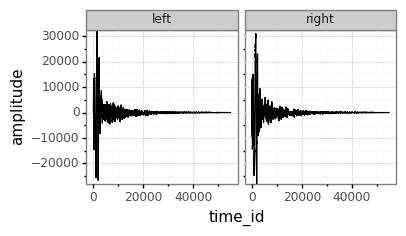

<ggplot: (8739591031225)>

In [3]:
(
    ggplot(bass_pd.melt(id_vars = ['time_id'], value_name='amplitude', var_name='stereo')) 
      + geom_line(aes(x = 'time_id', 
                      y = 'amplitude'))
      + facet_wrap('stereo') 
      + theme(figure_size=(4,2))
)

In [4]:
import glob

wav_files = glob.glob('sounds/kick/*.wav') + glob.glob('sounds/snare/*.wav') + glob.glob('sounds/tom/*.wav')
all_audio = pd.concat([audio_to_dataframe(path) for path in wav_files])
all_labels = pd.Series(np.repeat(['kick', 'snare', 'tom'], 25), 
                      index = wav_files)
all_audio.head()

,left,right,time_id,file_id
0,234,252,0,sounds/kick/Industrial-Kick-1.wav
1,157,168,1,sounds/kick/Industrial-Kick-1.wav
2,21,26,2,sounds/kick/Industrial-Kick-1.wav
3,472,499,3,sounds/kick/Industrial-Kick-1.wav
4,-138,-150,4,sounds/kick/Industrial-Kick-1.wav


## Generating features

- **What is TSfresh, keep it short and to the point**

In [5]:
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters
settings = MinimalFCParameters()

audio_tsfresh_minimal = extract_relevant_features(all_audio, all_labels, 
                                          column_id='file_id', column_sort='time_id', 
                                          default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 30/30 [00:00<00:00, 181.90it/s]


In [6]:
audio_tsfresh_minimal.shape

(75, 11)

In [8]:
from tsfresh.feature_extraction import EfficientFCParameters
settings = EfficientFCParameters()

audio_tsfresh = extract_relevant_features(all_audio, all_labels, 
                                          column_id='file_id', column_sort='time_id', 
                                          default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 30/30 [13:12<00:00, 26.42s/it]


In [9]:
audio_tsfresh.shape

(75, 327)

## Fitting regularised regression
#### Minimal TSfresh vs efficient

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

base_log_reg = LogisticRegression(penalty='l1', 
                                 multi_class='ovr',
                                 solver='saga',
                                 tol=1e-6,
                                 max_iter=int(1e4), 
                                 C=1)

In [11]:
from sklearn.model_selection import train_test_split

def get_score(audio_data, labels):
    # Replace by cross_val_score?
    audio_train, audio_test, label_train, label_test = train_test_split(audio_data, labels, test_size=0.3)
    log_reg = base_log_reg.fit(audio_train, label_train)
    return log_reg.score(audio_test, label_test)
rsquared_minimal = [get_score(audio_tsfresh_minimal, all_labels) for x in range(20)]
rsquared_efficient = [get_score(audio_tsfresh, all_labels) for x in range(20)]

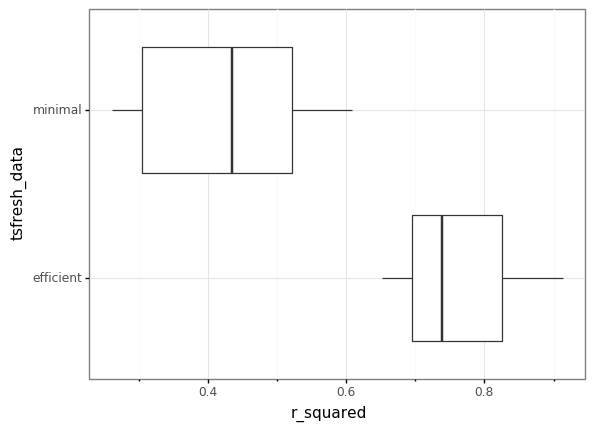

<ggplot: (8739534907837)>

In [12]:
plot_data = pd.concat([pd.DataFrame({'r_squared': rsquared_minimal, 'tsfresh_data': 'minimal'}),
                       pd.DataFrame({'r_squared': rsquared_efficient, 'tsfresh_data': 'efficient'})])
(
    ggplot(plot_data) + geom_boxplot(aes(x='tsfresh_data', y='r_squared')) + coord_flip()
)

#### Selecting regularisation strength through crossvalidation
##### Visualising path of the coefficients

In [20]:
cs = l1_min_c(audio_tsfresh_minimal, all_labels, loss='log') * np.logspace(0, 7, 16)
cv_result = LogisticRegressionCV(Cs=cs,
                     penalty='l1', 
                     multi_class='ovr',
                     solver='saga',
                     tol=1e-6,
                     max_iter=int(1e4)).fit(audio_tsfresh, all_labels)

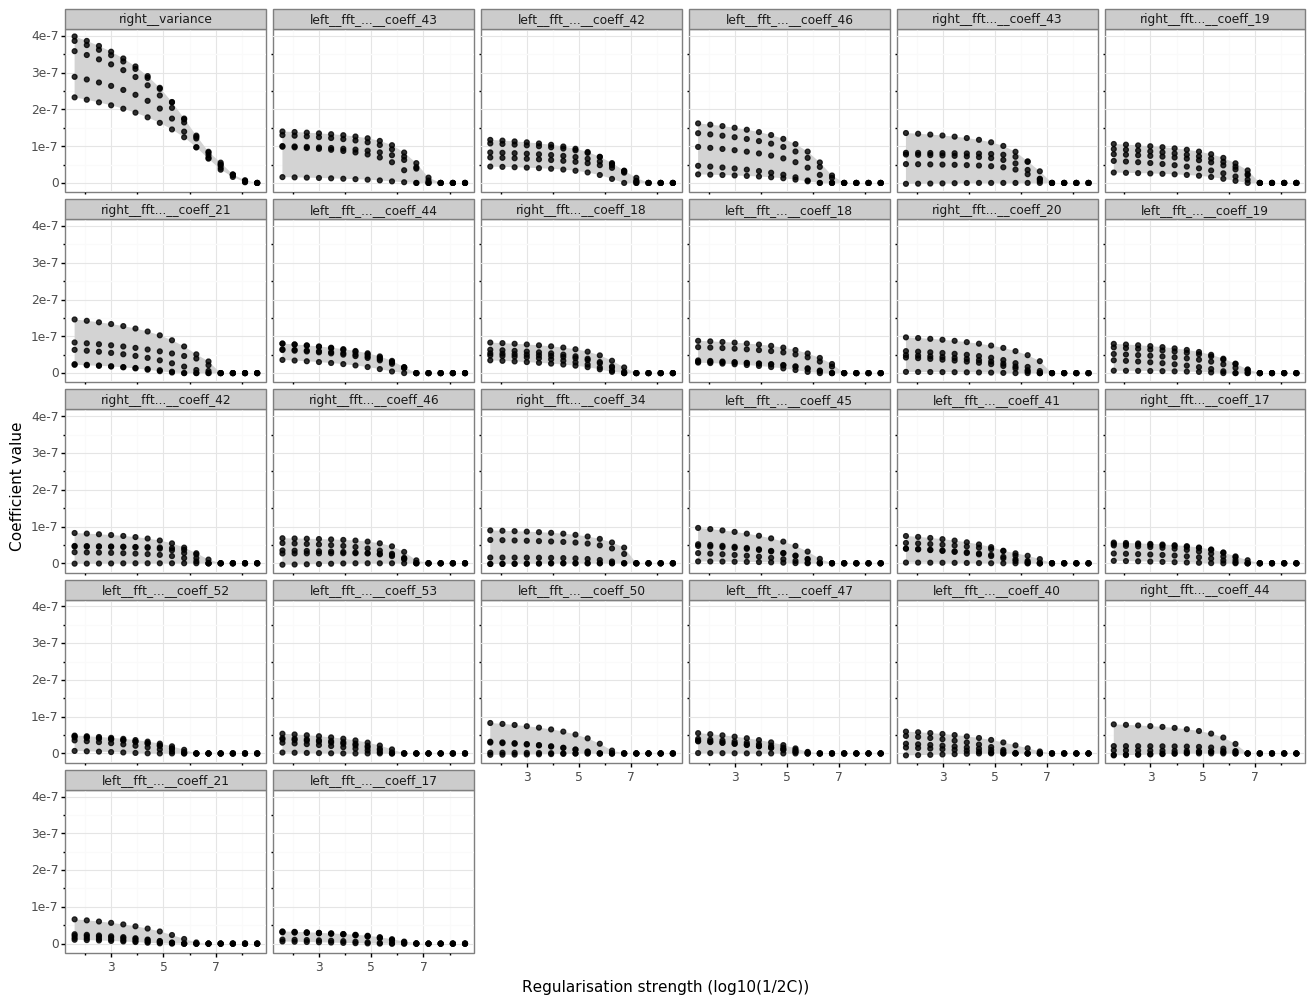

<ggplot: (8739535785805)>

In [56]:
plot_coef_paths(cv_result, 'kick', audio_tsfresh) + theme(figure_size=(16,12))

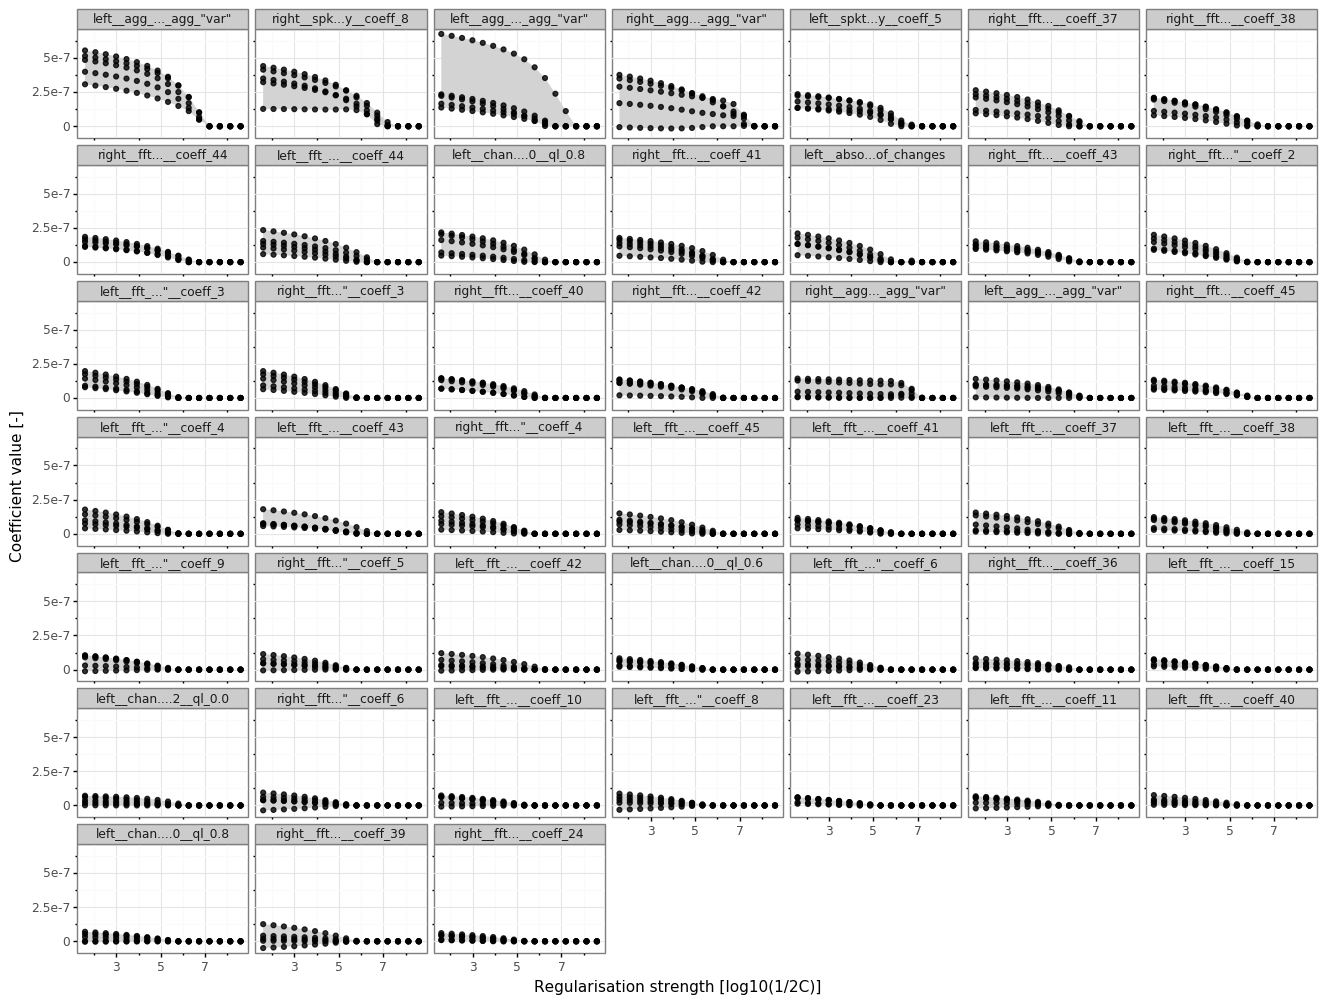

<ggplot: (8739536358661)>

In [71]:
plot_coef_paths(cv_result, 'snare', audio_tsfresh) + theme(figure_size=(16,12))

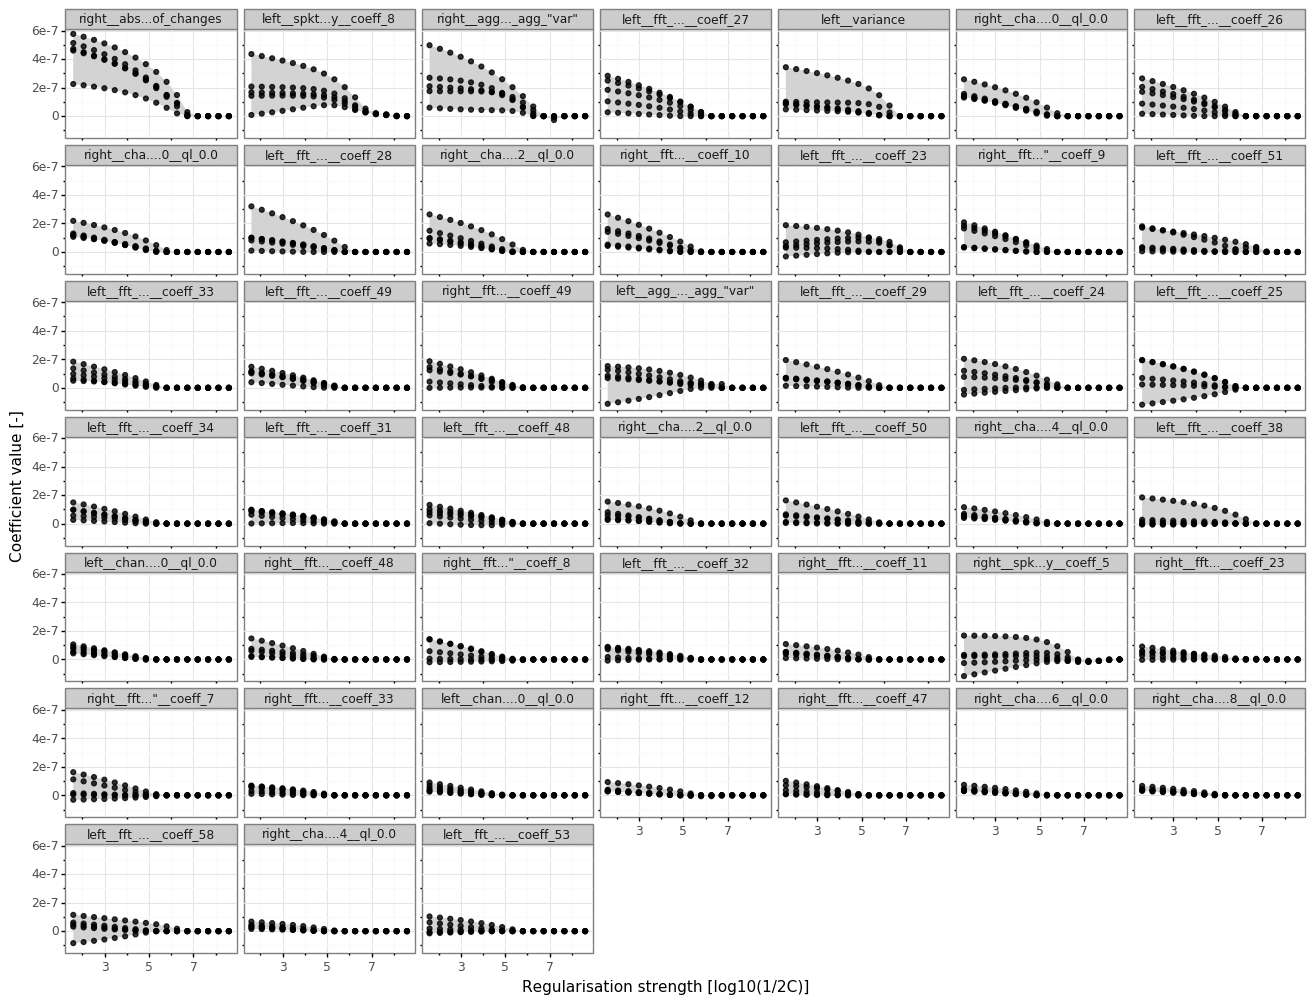

<ggplot: (8739541236913)>

In [72]:
plot_coef_paths(cv_result, 'tom', audio_tsfresh) + theme(figure_size=(16,12))

Add some interesting observations here:
- **The different models use different variables, The tom model seems to deviate the most**
- **Coefficient size drops stronlgy over the first few features**
- **The variance between the different folds is still quite strong for smaller reg strengths (i.e. problem is strongly underdetermined, the model does not really know what coef value to choose), even to the point of flipping between positive and negative. Increasing the reg strength reduces this effect, and the coefs between the folds com closer together.**
- **Increased regularisation strength reduces the coefficients, eliminating the completely after a certain strength. That is inline with our L1 norm we use.**

##### Visualising overall performance

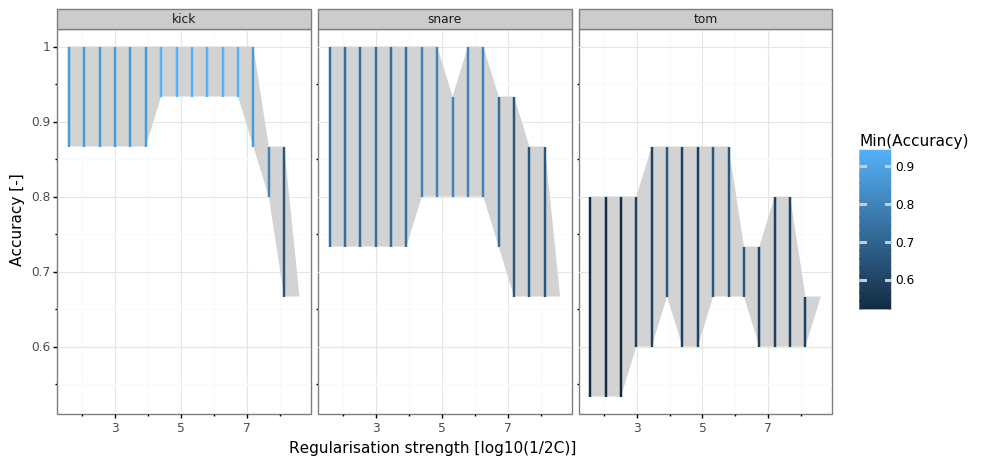

<ggplot: (8739540322729)>

In [59]:
plot_reg_strength_vs_score(cv_result) + theme(figure_size=(10,5))

Observations:
- Tom has the worst performing model with the lowest overall score.
- Kick performs best with the highest minimum score
- Performance peaks between a regularisation strength of 5-6. With a smaller strength I suspect too much noise from the superfluous variables, after that the regularisation takes out too much variables and thus information. 

The crossvalidation function chose the following regularisation strength values:

In [26]:
np.log10(1/(2*cv_result.C_))

array([6.72667956, 6.2600129 , 4.8600129 ])

When we predict back the data using the optimal model we get:

In [70]:
from sklearn.metrics import confusion_matrix

make_confusion_matrix(all_labels, cv_result.predict(audio_tsfresh), ['kick', 'tom', 'snare'])

,kick,tom,snare
kick,1.0,0.00,0.00
tom,0.0,0.84,0.16
snare,0.0,0.00,1.00


The confusion matrix confirms what we saw in the overall performance plot: kick is easiest to spot, 